## Aspect-Based Sentiment Analysis: Findings from Natural Language
#### Code File \#1: Data Engineering

Tahmeed Tureen - University of Michigan, Ann Arbor<br>
Python file: <b>data-engin-tureen.py</b> <br>
Description: Code to process the XML format dataset from 2014 SemEval Task 4

In [2]:
# Import Libraries
import xml.etree.ElementTree as ET # To Parse the XML data
import pandas as pd # import Pandas library
import pickle # for pickling Python data structures

### Part I: Process the Raw Data

In [3]:
# Read in XML data
tree = ET.parse('../SemEval_14_Train/Restaurants_Train_v2.xml')
# tree = ET.parse('../SemEval_14_Train/play.xml')
root = tree.getroot()

The data is nested like a tree because it's in XML format <br>
We will loop through all of the sentences (reviews) <br>
The whole XML data is nested under the root term: sentences <br>
This root has branches named "sentence" (individual review) and we have multiple of these

In [4]:
processed_reviews = [] # this list will contain dictionaries, eventually we will convert it to a Pandas DataFrame

for sen in root.findall("sentence"):
    # this dictionary will store the columns we are interested in storing for our processed dataset
    data_dict = {} 

    review = sen[0].text # assign the text review to this variable

    if sen.find("aspectTerms"): # if there exists aspect terms in review 

        # we make define these lists because a review can have multiple aspects
        term_tokens = [] # slot 1 for value_container
        term_pols = [] # slot 2 for value_container
        
        # Iterate through individual aspect terms and strip its polarity
        for branch in sen.find("aspectTerms").findall("aspectTerm"):
            term = branch.get("term")
            term_polarity = branch.get("polarity")

            term_tokens.append(term)
            term_pols.append(term_polarity)

    if sen.find("aspectCategories"): # if there exists labeled categories 

        # We define these lists because a review can have multiple aspects
        cat_tokens = [] # list of all of the labeled categories for the data
        cat_pols = [] # list of the associated polarities

        for branch in sen.find("aspectCategories").findall("aspectCategory"):
            category = branch.get("category")
            cat_polarity = branch.get("polarity")

            cat_tokens.append(category)
            cat_pols.append(cat_polarity)

    # Start assigning the values we just mined to appropriate keys in data_dict
    data_dict["Review ID"] = sen.attrib["id"]
    data_dict["Review"] = review
    data_dict["Aspect Term"] = term_tokens
    data_dict["Aspect Polarity"] = term_pols
    data_dict["Aspect Count"] = len(term_tokens)
    data_dict["Category"] = cat_tokens
    data_dict["Category Polarity"] = cat_pols
    data_dict["Category Count"] = len(cat_tokens)

    # each element in the following list will be a row for our processed dataset
    processed_reviews.append(data_dict) # append data_dict

We will convert this list into a Pandas DataFrame for convenience and also save it as a pickled file

In [5]:
reviews_pd = pd.DataFrame(processed_reviews)
print("Shape of Training data", reviews_pd.shape)
reviews_pd.head(3)

Shape of Training data (3041, 8)


,Aspect Count,Aspect Polarity,Aspect Term,Category,Category Count,Category Polarity,Review,Review ID
0,1,[negative],[staff],[service],1,[negative],But the staff was so horrible to us.,3121
1,1,[positive],[food],"[food, anecdotes/miscellaneous]",2,"[positive, negative]","To be completely fair, the only redeeming fact...",2777
2,3,"[positive, positive, neutral]","[food, kitchen, menu]",[food],1,[positive],"The food is uniformly exceptional, with a very...",1634


In [6]:
# Save data as pickled file so we can read it in easily later
reviews_pd.to_pickle("pickled_data/pickled_reviews_pd.pkl")
# test_pickle = pickle.load(open("pickled_reviews_pd.pkl", "rb"))

### Part II: Re-format Data

In this next section, we process the dataframe to create a new one that is re-formatted to an aspect level instead of review level. In the previous dataframe the rows represented an entire review whereas now a row will represent an individual aspect term

In [7]:
aspects_terms_pd = reviews_pd[['Review', 'Review ID', 'Aspect Term', 'Aspect Polarity', 'Aspect Count']]

aspects_data_list = []

for row in aspects_terms_pd.itertuples():

    terms_list = row[3]
    pols_list = row[4]

    # print(len(terms_list) == len(pols_list))

    for i in range(len(terms_list)):
        data_dict = {}

        data_dict["Review ID"] = row[2]
        data_dict["Review"] = row[1]

        pol = pols_list[i]

        if pol == "conflict":
            pol = "neutral"

        data_dict["Aspect Term"] = terms_list[i]
        data_dict["Aspect Polarity"] = pol
        data_dict["All Aspect Terms"] = terms_list

        aspects_data_list.append(data_dict)

In [8]:
# Convert to Pandas Data Frame for convenience
aspect_terms_pd = pd.DataFrame(aspects_data_list)
aspect_terms_pd = aspect_terms_pd[['Review', 'Review ID', 'Aspect Term', 'Aspect Polarity', 'All Aspect Terms']] # re-order

In [9]:
print("Dimension: ", aspect_terms_pd.shape)
aspect_terms_pd.head(3)

Dimension:  (5474, 5)


,Review,Review ID,Aspect Term,Aspect Polarity,All Aspect Terms
0,But the staff was so horrible to us.,3121,staff,negative,[staff]
1,"To be completely fair, the only redeeming fact...",2777,food,positive,[food]
2,"The food is uniformly exceptional, with a very...",1634,food,positive,"[food, kitchen, menu]"


Notice that the number of rows have changed. This means we have repeating reviews in this dataset and that's something we should keep in mind

In [10]:
## Save this as a pickled file also
aspect_terms_pd.to_pickle("pickled_data/pickled_aspect_terms_pd.pkl")

### Data Summarization/Visualizations

In this next section, we do some exploratory data summarization and visualizations

We are done processing our training data. Move onto processing our test data (Please note that we processed the test data after we had trained our models using the training data and already did some feature engineering/parameter tuning etc.; we avoided looking at the test data until the very end)

In [11]:
import matplotlib
from collections import Counter

In [12]:
# Let's look at the distribution of the Aspect Categories first
category_freq = []
for cat in reviews_pd['Category']:
    category_freq += cat
category_freq = Counter(category_freq)
category_freq

Counter({'ambience': 431,
         'anecdotes/miscellaneous': 1132,
         'food': 1232,
         'price': 321,
         'service': 597})

It looks like we have 5 aspect categories (as claimed by SemEval) and the distribution looks about the same as well!

In [79]:
# Let's now look at the distribution of the Aspect Terms
term_freq = Counter(aspect_terms_pd['Aspect Term'])
print("There are ", len(term_freq.keys()), "unique terms in the training data")
term_freq.most_common()[0:15]
term_freq_top15_x = [tup[0] for tup in term_freq.most_common()[0:15]]
term_freq_top15_y = [tup[1] for tup in term_freq.most_common()[0:15]]

There are  1288 unique terms in the training data


In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [102]:
index = np.arange(len(category_freq.keys()))
nums = category_freq.values()
labels = category_freq.keys()

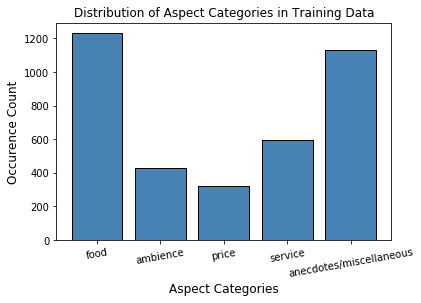

In [106]:
plt.bar(index, nums)
plt.bar(labels, nums, color='steelblue',  edgecolor='black')

# add additional features to plot
plt.title("Distribution of Aspect Categories in Training Data")
plt.ylabel("Occurence Count", fontsize = 12)
plt.xlabel("Aspect Categories", fontsize = 12)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.show()

Now we make a bar plot for the aspect terms

In [108]:
index = np.arange(len(term_freq_top15_x)) # for the xticks
index

objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Programming language usage')

Text(0.5,1,'Programming language usage')

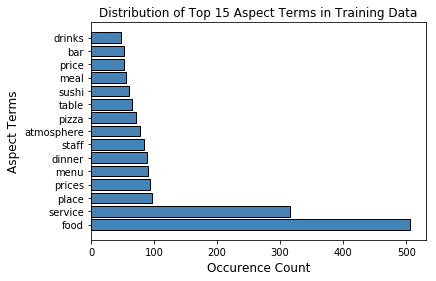

In [110]:
plt.barh(index, term_freq_top15_y,
         color='steelblue',  edgecolor='black')
plt.yticks(index, term_freq_top15_x, fontsize = 10)
plt.title("Distribution of Top 15 Aspect Terms in Training Data")
plt.ylabel("Aspect Terms", fontsize = 12)
plt.xlabel("Occurence Count", fontsize = 12)
plt.show()

#### Let's look at the Polarity Distribution next
We can just look at the counts of the positive, negative, and neutral sentiments in the category polarity column of our reviews_pd dataframe

In [113]:
# Let's look at the distribution of the Aspect Categories first
category_freq = []
for cat in reviews_pd['Category Polarity']:
    category_freq += cat
category_freq = Counter(category_freq)
category_freq

# 500 + 195

Counter({'conflict': 195, 'negative': 839, 'neutral': 500, 'positive': 2179})